In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp search

In [3]:
#export
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd

dev


In [4]:
#export
## temp while api is not aperational
# from food.clipmodel import *
from PIL import Image

In [5]:
# #export
# foods = read_sql('foods')
# # foods = foods.drop(columns = ['clip'])
# foods = foods.set_index('id')

In [6]:
#export
q = """select  i.food_id,f.description, f.category,f.energy,f.protein,f.carb,f.fat,i.clip,i.id 
               from food.foods_prompted_images i 
               join food.foods f on (f.id = i.food_id)"""
foods = pd.read_sql(q,engine).set_index('id')

In [7]:
len(foods)

35346

In [8]:
def mean_vector(g):
    return series2tensor(g).mean(0).reshape(768).detach().clone()

In [9]:
#export
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)



In [12]:
url = 'https://image.shutterstock.com/z/stock-photo-fresh-tasty-burger-isolated-on-white-background-705104968.jpg'

In [ ]:
http://127.0.0.1:8184/get_boxes/?url=

In [17]:
boxes = requests.post(f'http://127.0.0.1:8184/get_boxes/?url={url}').json()

In [ ]:
response = requests.get(url)
image_bytes = io.BytesIO(response.content)
image_init = Image.open(image_bytes).convert("RGB")
image_init.crop(images[2])

In [10]:
#export
def search_image_(url=None,head = 1,env='dev'):
    client = dev_client if env == 'dev' else prod_client
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [11]:
#export
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

In [12]:
#export
def multiple_foods(url,env='dev'):

    image_clip,selected = search_image_(url,head=100,env=env)
    # selected=selected[selected['category'].isin(selected_categories)]
    selected=selected.reset_index(drop=True)
    clip = series2tensor(selected['clip'])
    initscore = float(cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768)).detach().clone())
    startscore = initscore-0.0000001
    n=0

    while startscore !=initscore:
        startscore = initscore
        
        selected = selected.reset_index(drop=True)
        for i in reversed(selected.index):
            clip = series2tensor(selected['clip'])
            dropped = drop_vector(clip,i)
            testscore = float(cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768)).detach().clone())

            if testscore > initscore-0.0001: 
                r = selected.loc[i,'description']
                selected = selected.drop(i)
                initscore = testscore

            else:
                extra = multiply_vector(clip,i,1)
                testscore = float(cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768)).detach().clone())
                if testscore > initscore: 
                    selected = selected.append(selected.loc[i])
                    initscore = testscore

            n+=1
            if n ==15:break

        print(initscore)
    count = selected.groupby('description')['clip'].count().sort_index()
    r = selected.drop_duplicates('description').set_index("description").sort_index()
    r['count'] = count
    r = r.sort_values('count',ascending = False)
    r['share'] = r['count'].cumsum()/r['count'].sum()

    description = '. '.join(r[r['share']<0.9].index.unique().tolist())


    return r.drop(columns = ['clip']), description, selected,initscore
    

In [13]:
#export
def search_image(url,env='dev'):
    r, desc, sel,score = multiple_foods(url,env=env)
    df = sel[['energy','protein','carb','fat','score']].mean().to_frame().T
    df['score'] =score
    df['description'] = desc
    return df


In [14]:
url = 'https://image.shutterstock.com/z/stock-photo-fresh-tasty-burger-isolated-on-white-background-705104968.jpg'

In [15]:
r, desc, sel,score = multiple_foods(url,env='prod')

/tmp/ipykernel_178094/3265430290.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


0.9241994199612956
0.9489574442447687
0.9554999711028429
0.9556667475742928
0.9557574340674231
0.955895068238691
0.955895068238691


In [16]:
desc

'Egg, cheese and sausage on bagel. Hamburger, from fast food, 1 large patty. Soft drink, root beer, diet. Egg, cheese, ham, and bacon on bun. Hamburger (McDonalds). Cheeseburger, from fast food, 1 large patty'

In [17]:
r

,id,food_id,category,energy,protein,carb,fat,score,count,share
description,,,,,,,,,,
"Egg, cheese and sausage on bagel",43648,1100331,Egg/breakfast sandwiches (single code),295.0,12.98,22.64,16.97,0.842053,4,0.20
"Hamburger, from fast food, 1 large patty",34101,1099802,Burgers (single code),289.0,18.43,17.12,15.63,0.889186,4,0.40
"Soft drink, root beer, diet",101947,1104328,Diet soft drinks,0.0,0.10,0.00,0.00,0.862068,4,0.60
"Egg, cheese, ham, and bacon on bun",43328,1100315,Egg/breakfast sandwiches (single code),250.0,14.48,17.25,13.23,0.840220,2,0.70
Hamburger (McDonalds),33987,1099796,Burgers (single code),263.0,13.30,29.57,10.18,0.865655,2,0.80
"Cheeseburger, from fast food, 1 large patty",33686,1099781,Burgers (single code),300.0,18.79,15.15,17.68,0.892620,1,0.85
"Double hamburger, on white bun, 2 medium patties",34266,1099810,Burgers (single code),290.0,19.51,13.02,17.09,0.889645,1,0.90
"Double hamburger, on white bun, 2 small patties",34232,1099808,Burgers (single code),289.0,19.18,14.26,16.65,0.889645,1,0.95
Hamburger slider,34021,1099798,Burgers (single code),288.0,17.76,19.71,14.72,0.872722,1,1.00


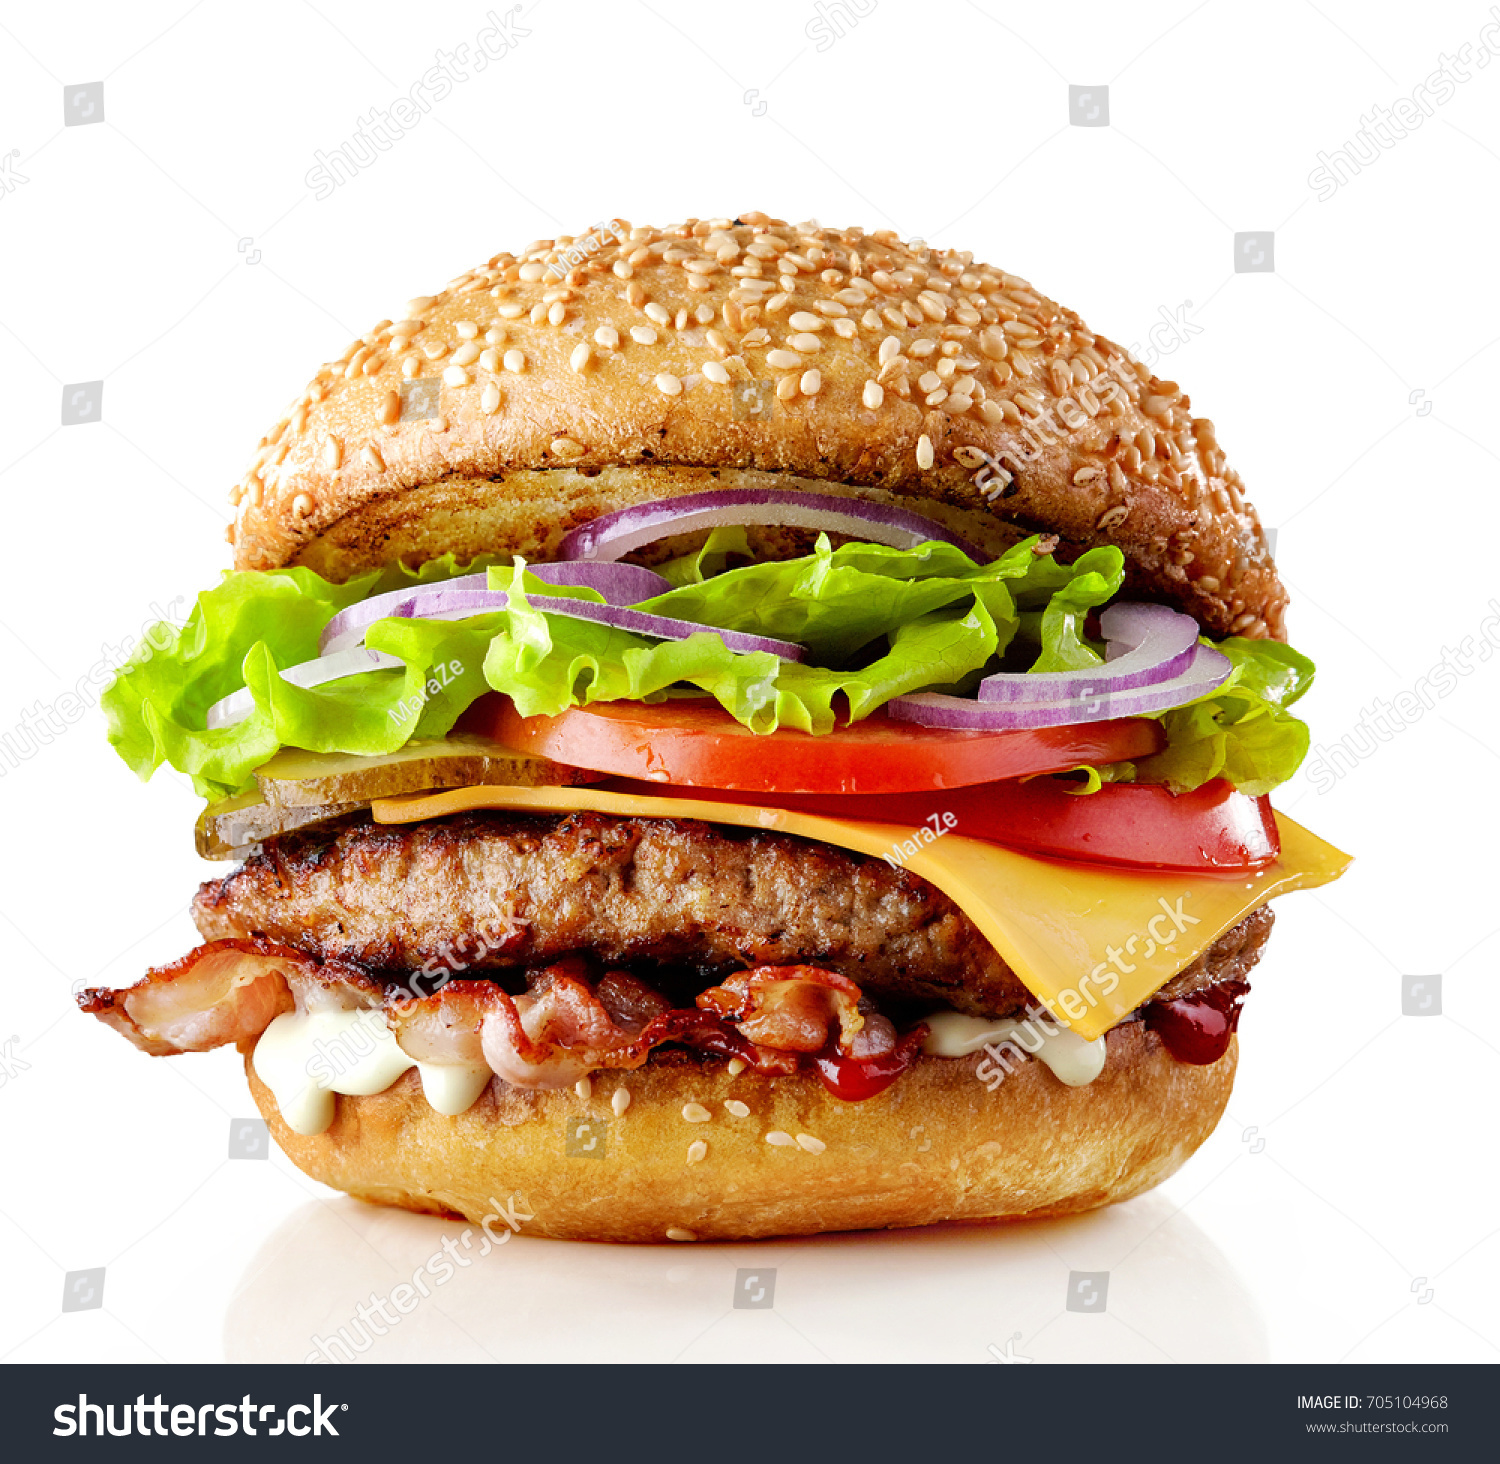

In [18]:
get_image_from_url(url)

In [19]:
search_image(url,'prod')

0.9241994199612956
0.9489574442447687
0.9554999711028429
0.9556667475742928
0.9557574340674231
0.955895068238691
0.955895068238691


,energy,protein,carb,fat,score,description
0,226.45,12.842,15.741,12.168,0.955895,"Egg, cheese and sausage on bagel. Hamburger, f..."


In [20]:
!nbdev_build_lib

Converted 00_clipmodel.ipynb.
Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_progress_check.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_tools.ipynb.
Converted 01_search.ipynb.
Converted inference.ipynb.
Converted stats.ipynb.
